# Cleaning Emails:

In [1]:
#Load necessary libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [2]:
#Loading the data:
categories = [
    'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc'
]
#Extracting train data and saving it into "data" list
import os
data = []
for i in categories:
    file_numbers = os.listdir('20news-bydate-train/'+i)
    for j in range(len(file_numbers)):
        with open('20news-bydate-train/'+i+'/'+file_numbers[j]) as f:
            data.append((i, f.read()))

#Extracting test data and saving it into "data" list
for i in categories:
    file_numbers = os.listdir('20news-bydate-test/'+i)
    for j in range(len(file_numbers)):
        with open('20news-bydate-test/'+i+'/'+file_numbers[j]) as f:
            data.append((i, f.read()))
print(len(data))

18846


In [3]:
#Convert "data" list to DataFrame
data = pd.DataFrame(data, columns=['target', 'email'])
data.head()

,target,email
0,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...
1,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...
2,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...
3,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...
4,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...


In [30]:
#Drop duplicates in the data
data.drop_duplicates(inplace=True)
data.groupby('target').describe()

email                                                               
       count unique                                                top freq
target                                                                     
0        799    799  from edm twisto compaq com ed mccreary subject...    1
1        973    973  from tmc spartan ac brocku ca tim ciceran subj...    1
2        985    985  from avinash silver lcs mit edu avinash chopde...    1
3        982    982  from guyd austin ibm com guy dawson subject re...    1
4        963    963  from blast nntp crl com tim keanini subject at...    1
5        988    988  from markw pspmf3 gpsemi com mark wilkinson ex...    1
6        973    973  from goldsman cc gatech edu michael g goldsman...    1
7        990    990  from tommy boole att com tommy reingold subjec...    1
8        996    996  from ranck joesbar cc vt edu wm l ranck subjec...    1
9        994    994  from mark b subject you could look it up organ...    1
10       999    999  from jpc philabs philips com john p curcio sub...    1
11       991    991  from strnlght netcom com david sternlight subj...    1
12       984    984  from me170pjd emba news uvm edu uucp peter j d...    1
13       990    990  from wcsbeau alfred carleton ca opirg subject ...    1
14       987    987  from leech cs unc edu jon leech subject space ...    1
15       997    997  from news cbnewsk att com subject re question ...    1
16       910    910  from julie eddie jpl nasa gov julie kangas sub...    1
17       940    940  from bc744 cleveland freenet edu mark ira kauf...    1
18       775    775  from as010b uhura cc rochester edu tree of sch...    1
19       628    628  from irfan davinci ece wisc edu irfan alan sub...    1

In [5]:
#Take a look at the contents of an email
data['email'][2]

'From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Rosenau)\nSubject: Re: Gospel Dating\nOrganization: Technical University Braunschweig, Germany\nLines: 93\n\nIn article <65974@mimsy.umd.edu>\nmangoe@cs.umd.edu (Charley Wingate) writes:\n \n>>Well, John has a quite different, not necessarily more elaborated theology.\n>>There is some evidence that he must have known Luke, and that the content\n>>of Q was known to him, but not in a \'canonized\' form.\n>\n>This is a new argument to me.  Could you elaborate a little?\n>\n \nThe argument goes as follows: Q-oid quotes appear in John, but not in\nthe almost codified way they were in Matthew or Luke. However, they are\nconsidered to be similar enough to point to knowledge of Q as such, and\nnot an entirely different source.\n \n \n>>Assuming that he knew Luke would obviously put him after Luke, and would\n>>give evidence for the latter assumption.\n>\n>I don\'t think this follows.  If you take the most traditional attributions,\n>then Luke might 

In [31]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

data['email'] = data['email'].apply(preprocessor)
data['email'][2]

'from i3150101 dbstu1 rz tu bs de benedikt rosenau subject re gospel dating organization technical university braunschweig germany lines 93 in article mangoe cs umd edu charley wingate writes well john has a quite different not necessarily more elaborated theology there is some evidence that he must have known luke and that the content of q was known to him but not in a canonized form this is a new argument to me could you elaborate a little the argument goes as follows q oid quotes appear in john but not in the almost codified way they were in matthew or luke however they are considered to be similar enough to point to knowledge of q as such and not an entirely different source assuming that he knew luke would obviously put him after luke and would give evidence for the latter assumption i don t think this follows if you take the most traditional attributions then luke might have known john but john is an elder figure in either case we re talking spans of time here which are well with

In [32]:
#Let's convert categorical target values into numerical values from 0 to 19
class_le = LabelEncoder()
data['target'] = class_le.fit_transform(data['target'].values)
data.head()

,target,email
0,0,from mathew subject alt atheism faq atheist re...
1,0,from mathew subject alt atheism faq introducti...
2,0,from i3150101 dbstu1 rz tu bs de benedikt rose...
3,0,from mathew subject re university violating se...
4,0,from strom watson ibm com rob strom subject re...


## Applying Bag of Words:

In this section, we will convert emails into vectors containing numbers. We will use bag of words approach, where each unique word in a text will be represented by one number.

In [33]:
#Load necessary libraries:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\h\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\h\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\h\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\h\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We will tokenize words in text, remove stop words (commonly used English words that do not contribute in decision making) and normalize words into their base forms (lemmas) with the following code: 

In [34]:
stop = stopwords.words('english')
stop = stop + [u'a',u'b',u'c',u'd',u'e',u'f',u'g',u'h',u'i',u'j',u'k',u'l',u'm',u'n',u'o',u'p',u'q',u'r',u's',u't',u'v',u'w',u'x',u'y',u'z']

def tokenize_lemmas(email):
    email = str(email).lower()
    words = TextBlob(email).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words if word not in stop]

We will tokenize words in text, remove stop words (commonly used English words that do not contribute in decision making) and normalize words into their base forms (lemmas) with the following code: 

In [35]:
bow_transformer = CountVectorizer(analyzer=tokenize_lemmas).fit(data['email'])

print(len(bow_transformer.vocabulary_))

130659


In [36]:
data_bow = bow_transformer.transform(data['email'])
print('sparse matrix shape:', data_bow.shape)
print('number of non-zeros:', data_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * data_bow.nnz / (data_bow.shape[0] * data_bow.shape[1])))

sparse matrix shape: (18844, 130659)
number of non-zeros: 2188615
sparsity: 0.09%


Now the data is ready, we can split it into training and testing sets. First 12,000 documents will be in the training set. The remaining 6,844 will be in the testing set. 

In [50]:
bow_train = data_bow[:12000]
bow_test = data_bow[12000:]
sentiment_train = data['target'][:12000]
sentiment_test = data['target'][12000:]

In [51]:
def acc_conf_mat(train, test, pred_train,pred_test):
    train_score = accuracy_score(train, pred_train) * 100
    print(f"Train accuracy score: {train_score:.2f}%")
    test_score = accuracy_score(test, pred_test) * 100
    print(f"Test accuracy score: {test_score:.2f}%")
    print(classification_report(test, pred_test))
    cm = confusion_matrix(test, pred_test)
    cmd = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(10,10))
    cmd.plot(ax=ax)

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(bow_train, sentiment_train)
train_pred = lr.predict(bow_train)
test_pred = lr.predict(bow_test)

C:\Users\h\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy score: 100.00%
Test accuracy score: 80.08%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.07      0.80      0.13        20
           2       0.76      0.68      0.72       394
           3       0.69      0.69      0.69       392
           4       0.78      0.83      0.81       385
           5       0.87      0.68      0.77       395
           6       0.79      0.87      0.83       390
           7       0.89      0.85      0.87       396
           8       0.93      0.92      0.93       398
           9       0.89      0.91      0.90       397
          10       0.93      0.93      0.93       399
          11       0.95      0.88      0.91       396
          12       0.74      0.73      0.73       393
          13       0.89      0.79      0.84       396
          14       0.94      0.88      0.91       394
          15       0.86      0.90      0.88       398
          16       0.73

C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


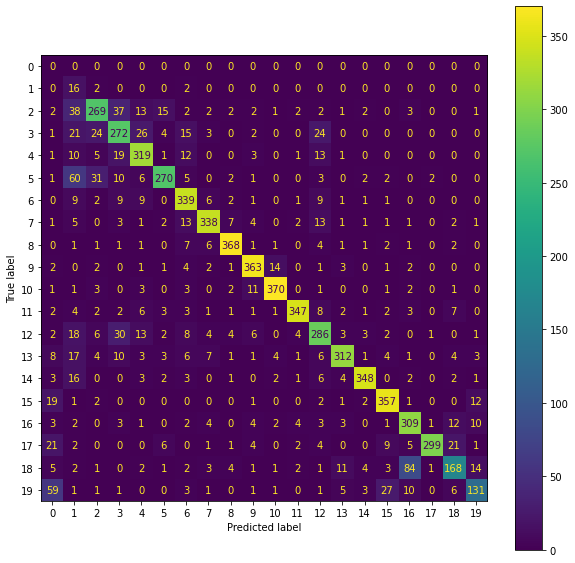

In [53]:
acc_conf_mat(sentiment_train, sentiment_test, train_pred, test_pred)

## Applying TfidfVectorizer:

The process above can be replaced by TfidfVectorizer(). Let's see how it will perform:

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
X = vectorizer.fit_transform(data['email'])
vectorizer.get_feature_names_out()


array(['00', '000', '0000', ..., 'óáíïìåô', 'ýé', 'ÿhooked'], dtype=object)

In [56]:
X.shape

(18844, 139769)

In [57]:
X.data[0]

0.008334651761902945

In [59]:
X_train = X[:12000]
X_test = X[12000:]
y_train = data['target'][:12000]
y_test = data['target'][12000:]

In [60]:
from sklearn.linear_model import LogisticRegression
lr_tf = LogisticRegression()
lr_tf.fit(X_train, y_train)
train_pred = lr_tf.predict(X_train)
test_pred = lr_tf.predict(X_test)

C:\Users\h\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy score: 97.67%
Test accuracy score: 80.68%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.04      0.85      0.08        20
           2       0.79      0.70      0.74       394
           3       0.76      0.70      0.73       392
           4       0.85      0.81      0.83       385
           5       0.90      0.67      0.77       395
           6       0.80      0.85      0.82       390
           7       0.91      0.88      0.89       396
           8       0.96      0.94      0.95       398
           9       0.93      0.91      0.92       397
          10       0.94      0.95      0.95       399
          11       0.97      0.89      0.93       396
          12       0.79      0.72      0.75       393
          13       0.92      0.82      0.87       396
          14       0.92      0.87      0.89       394
          15       0.87      0.89      0.88       398
          16       0.74 

C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\h\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


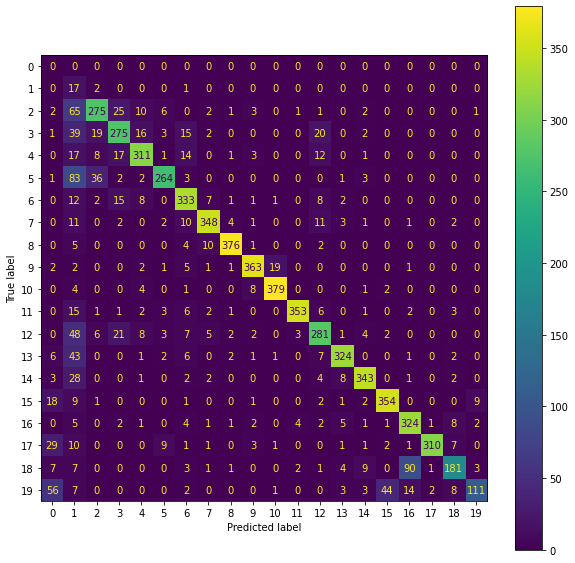

In [61]:
acc_conf_mat(y_train, y_test, train_pred, test_pred)

In [ ]:
Both techniques gave similar results.